In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Nacitanie iris datasetu
# X - features (data)
# y - triedy (setosa, versicolor, virginica)
# Strukturovany dataset (riadky, stlpce)
iris = load_iris()
X = iris.data
y = iris.target

epochs=100

In [3]:
print("Dataset shape:", X.shape)
print("Labels:", set(y))
print("Classes:", iris['target_names'])

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

Dataset shape: (150, 4)
Labels: {0, 1, 2}
Classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Rozdelenie datasetu na trenovaciu a testovaciu cast (test_size = 0.3 znamena 30% testovacia cast)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
# Vizualizacia datasetu pomocou bodoveho grafu
def create_scatter_plot(X, y, features, title):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=16)

    # Vizualizacia kazdeho paru features
    plot_number = 1
    for i in range(len(features)):
        for j in range(len(features)):
            if i < j:
                plt.subplot(2, 3, plot_number)
                for target in np.unique(y):
                    subset = X[y == target]
                    plt.scatter(subset[:, i], subset[:, j], label=iris.target_names[target])
                plt.xlabel(features[i])
                plt.ylabel(features[j])
                plt.legend()
                plot_number += 1

    plt.show()

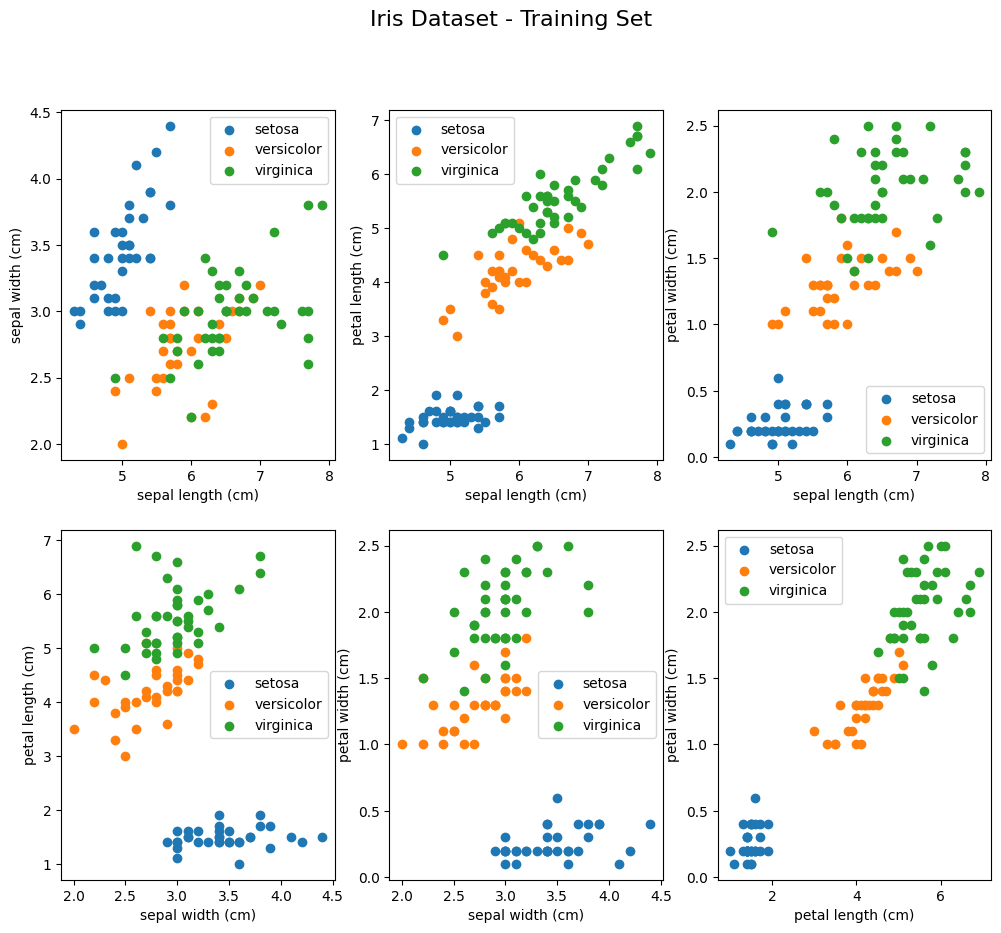

In [6]:
# Vizualizacia trenovacieho setu
create_scatter_plot(X_train, y_train, iris.feature_names, 'Iris Dataset - Training Set')

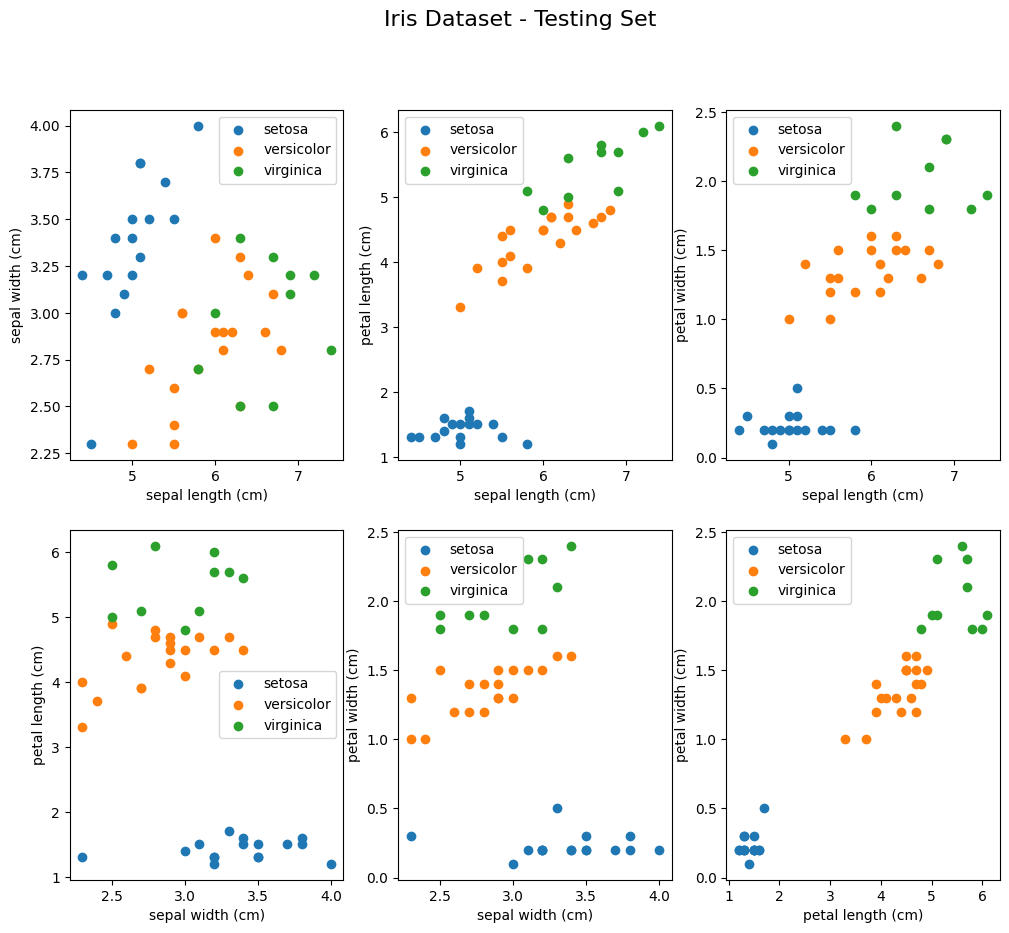

In [7]:
# Vizualizacia testovacieho setu
create_scatter_plot(X_test, y_test, iris.feature_names, 'Iris Dataset - Testing Set')

In [8]:
# Standardizacia datasetu
scaler = StandardScaler()
# fit_transform - vypocitanie mean a standard deviation, nasleduje transformacia trenovacic dat
X_train = scaler.fit_transform(X_train)
# tranformacia testovacich dat pomocou rovnakej mean a sd value
X_test = scaler.transform(X_test)

In [9]:
# Konvertovanie na tensory
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
# Vytvorenie dataset objektov
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Vytvorenie loaderov pre loadovanie dat pocas treningu, poskytovanie dat v kazdej iteracii podla batch_size
# shuffle = True pri trenovani pre zredukovanie rizika overfittingu
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [11]:
# MLP Model: Strukturovane datasety
# CNN Model: Spracovanie obrazkov..., spatial data
# RNN Model: NLP, voice recognition..., sekvencne data

In [12]:
# Definovanie MLP Modelu
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        # 4 input features, 8 neuronov
        self.fc1 = nn.Linear(4, 10)
        # Hidden layer - 10 neuronov
        self.fc2 = nn.Linear(10, 10)
        # output layer, 3 output features
        self.fc3 = nn.Linear(10, 3)

    # Metoda pre predikciu, zavola sa po vlozeni dat do modelu
    def forward(self, x):
        x = self.fc1(x)
        # Aplikovanie relu pre hidder layer
        # rectified linear unit
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Definovanie CNN Modelu
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Vytvorenie konvolucnej vrstvy, feature extraction
        # atributy - 1 input channel, 16 output channels, filter size 3 (filter nad datami)
        self.conv1 = nn.Conv1d(1, 16, 3)
        # 1D pooling layer - window size 2, vypocet maximalnej hodnoty z dvoch skumanych prvkov na vstupe,
        # redukovanie data size na polovicu, konsoliduje data
        self.pool = nn.MaxPool1d(2)
        # 1 feature size, 3 output size (3 triedy)
        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        # Add a channel dimension
        x = x.unsqueeze(1)
        # Aplikovanie relu na konvolucnu vrstvu
        x = torch.relu(self.conv1(x))
        # pooling layer
        x = self.pool(x)
        # Transformacia tenzoru z pooling layer na 1D
        x = x.view(x.size(0), -1)
        # Aplikovanie Linearnej vrstvy na vytvorenie outputu
        x = self.fc1(x)
        return x

In [14]:
# Definovanie RNN Modelu
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        # long-short term memory layer
        # single feature
        # 8 hidden units (8 neuronov)
        # batch_first specifikuje input shape (batch_size, sequence_length, input_size)
        self.rnn = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        # Linearna vrstva, output 3 classy
        self.fc = nn.Linear(8, 3)

    def forward(self, x): 
        # Prida input_size do tensora (predtym batch_size, sequence_length)
        x = x.unsqueeze(2)
        # Pass data through LSTM layer
        x, _ = self.rnn(x)
        # Take the last time step
        x = x[:, -1, :]
        # Output z LSTM layer do Linear Layer (fully connected, shape (batch_size, 3))
        x = self.fc(x)
        return x

In [15]:
# Trenovaci loop, pouziva back propagation
def train(model, criterion, optimizer, epoch_number):
    losses_mean = []
    loss_vall_arr = []
    acc_arr = []

    final_epochs = 0
    prev_accuracy = 0.0
    same_accuracy_count = 0

    precisions = []
    recalls = []
    
    for epoch in range(epoch_number):
        losses = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            # Ziska output pre dany input iteracie
            outputs = model(inputs)
            # vypocet loss medzi predikciami a skutocnymi labelmi
            loss = criterion(outputs, labels)
            # Pripocita loss
            losses += loss.detach().numpy()
            # Vypocet gradientov
            loss.backward()
            # Update modelu na zaklade vypocitanych gradientov
            optimizer.step()
        # Priemerny loss pre kazdu epochu trenovania
        avg_loss = losses / len(train_loader)
        
        losses_mean.append(avg_loss)

        # Evaluacia pre kazdu epochu, vracia accuracy a loss value
        acc, loss_vall, precision, recall = evaluate_model(model, train_loader)
        acc_arr.append(acc)
        loss_vall_arr.append(loss_vall)
        final_epochs += 1

        print(f'Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {acc}%, Precision: {precision}, Recall: {recall}')

        precisions.append(precision)
        recalls.append(recall)

        # Check for consecutive loss increases
        if epoch > 0 and avg_loss > losses_mean[-2]:
            increase_count += 1
            if increase_count >= 3:
                print("Stopping early due to increasing loss.")
                break
        else:
            increase_count = 0  # Reset the counter if loss decreases
        
    return losses_mean, loss_vall_arr, acc_arr, precisions, recalls, final_epochs

In [16]:
# Funkcia pre vyhodnotenie modelu na testovacich datach
def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    losses = 0
    losses_mean = []

    predicted_labels = []
    true_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predicted_labels.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
            
    losses_mean.append(losses/len(train_loader))
    accuracy = 100 * correct / total
    return accuracy, losses_mean, precision, recall

In [17]:
def visualise(loss_vall_arr, acc_arr, precisions, recalls, epochs):
    epochs = range(0, epochs)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss_vall_arr, label='valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs,acc_arr, label='acc', color = 'orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy %")
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, precisions, label='precision', color = 'red')
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, recalls, label='recalls', color = 'blue')
    plt.xlabel("Epochs")
    plt.ylabel("Recalls")
    plt.legend()

    plt.tight_layout()
    plt.show()

MLP
Epoch 1, Loss: 1.1132840615398478, Accuracy: 32.38095238095238%, Precision: 0.10485260770975056, Recall: 0.3238095238095238
Epoch 2, Loss: 1.0085846129453406, Accuracy: 32.38095238095238%, Precision: 0.10485260770975056, Recall: 0.3238095238095238
Epoch 3, Loss: 0.8716047957258405, Accuracy: 47.61904761904762%, Precision: 0.5046548956661316, Recall: 0.47619047619047616
Epoch 4, Loss: 0.77510075580399, Accuracy: 68.57142857142857%, Precision: 0.5051851851851852, Recall: 0.6857142857142857


/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Epoch 5, Loss: 0.6910337440247806, Accuracy: 73.33333333333333%, Precision: 0.8109690122536368, Recall: 0.7333333333333333
Epoch 6, Loss: 0.6139530092829241, Accuracy: 82.85714285714286%, Precision: 0.8491675644616822, Recall: 0.8285714285714286
Epoch 7, Loss: 0.5457086500905033, Accuracy: 86.66666666666667%, Precision: 0.8826622110832637, Recall: 0.8666666666666667
Epoch 8, Loss: 0.4624299769342508, Accuracy: 89.52380952380952%, Precision: 0.902448497129348, Recall: 0.8952380952380953
Epoch 9, Loss: 0.4027598089766952, Accuracy: 90.47619047619048%, Precision: 0.910128364389234, Recall: 0.9047619047619048
Epoch 10, Loss: 0.34591578467274614, Accuracy: 91.42857142857143%, Precision: 0.9180301180301179, Recall: 0.9142857142857143
Epoch 11, Loss: 0.30707035239188457, Accuracy: 93.33333333333333%, Precision: 0.9346147761430154, Recall: 0.9333333333333333
Epoch 12, Loss: 0.26418704706472607, Accuracy: 92.38095238095238%, Precision: 0.9241066541559152, Recall: 0.9238095238095239
Epoch 13, Lo

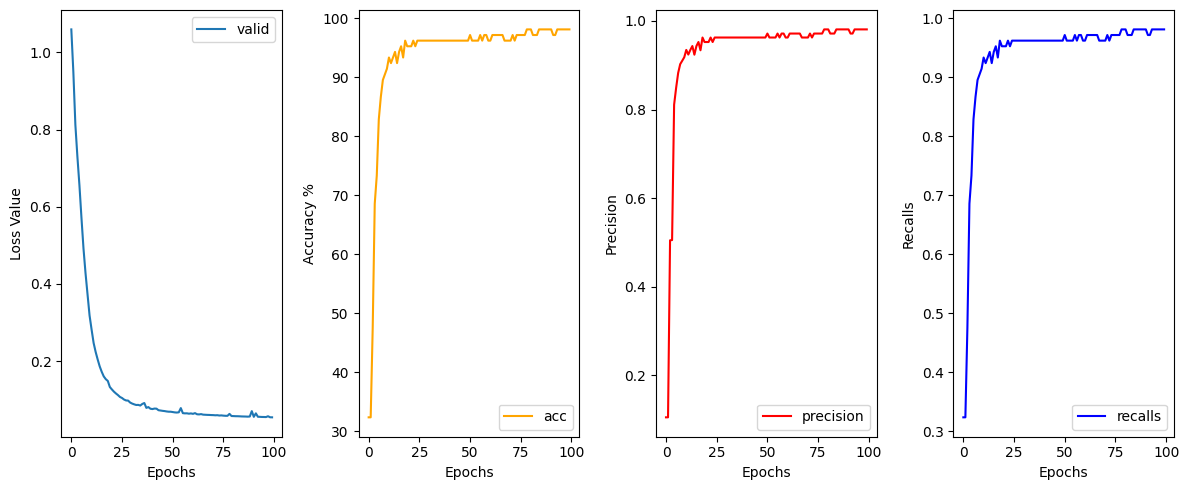

CNN
Epoch 1, Loss: 1.0464515674788997, Accuracy: 57.142857142857146%, Precision: 0.6340102707749767, Recall: 0.5714285714285714
Epoch 2, Loss: 0.9093842697593401, Accuracy: 78.0952380952381%, Precision: 0.8249886621315192, Recall: 0.780952380952381
Epoch 3, Loss: 0.8034384503679456, Accuracy: 77.14285714285714%, Precision: 0.8094068504594821, Recall: 0.7714285714285715


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 4, Loss: 0.7173968666004684, Accuracy: 77.14285714285714%, Precision: 0.8094068504594821, Recall: 0.7714285714285715
Epoch 5, Loss: 0.6449977856762005, Accuracy: 80.0%, Precision: 0.8220847935133648, Recall: 0.8
Epoch 6, Loss: 0.5937821763866352, Accuracy: 80.0%, Precision: 0.8220847935133648, Recall: 0.8
Epoch 7, Loss: 0.5349241551363243, Accuracy: 83.80952380952381%, Precision: 0.8593790556054706, Recall: 0.8380952380952381
Epoch 8, Loss: 0.4940686791010623, Accuracy: 84.76190476190476%, Precision: 0.8663582032003085, Recall: 0.8476190476190476
Epoch 9, Loss: 0.46324817498899856, Accuracy: 84.76190476190476%, Precision: 0.8663582032003085, Recall: 0.8476190476190476
Epoch 10, Loss: 0.43635969524675944, Accuracy: 85.71428571428571%, Precision: 0.8733706816059759, Recall: 0.8571428571428571
Epoch 11, Loss: 0.40781036426998535, Accuracy: 86.66666666666667%, Precision: 0.880453514739229, Recall: 0.8666666666666667
Epoch 12, Loss: 0.3860952300283144, Accuracy: 86.66666666666667%, Pr

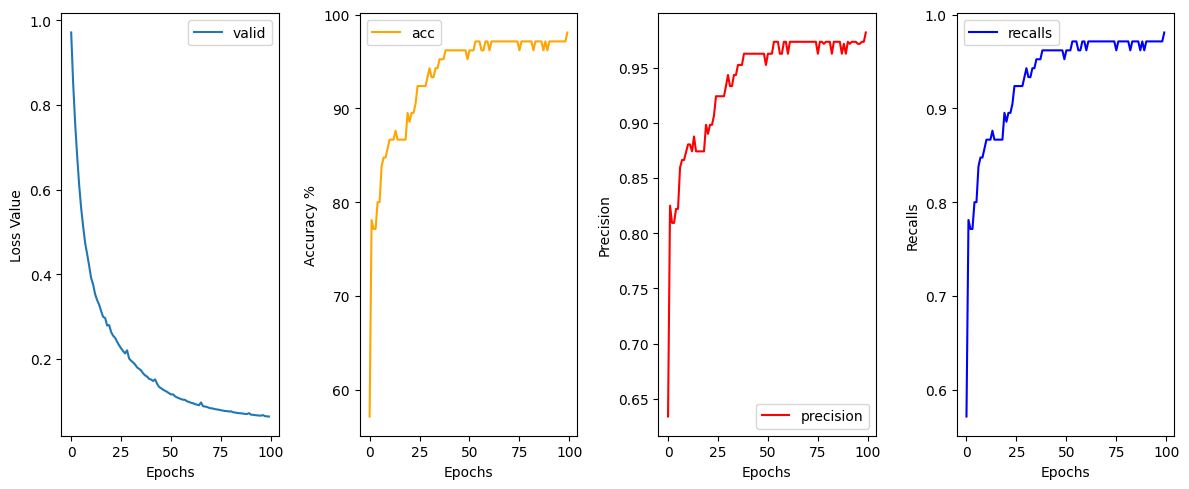

RNN
Epoch 1, Loss: 1.0804292042300385, Accuracy: 38.095238095238095%, Precision: 0.14512471655328799, Recall: 0.38095238095238093
Epoch 2, Loss: 1.0289192267183989, Accuracy: 40.95238095238095%, Precision: 0.47320261437908495, Recall: 0.4095238095238095


/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Epoch 3, Loss: 0.9708694624450972, Accuracy: 69.52380952380952%, Precision: 0.5229931972789116, Recall: 0.6952380952380952
Epoch 4, Loss: 0.8974515615769152, Accuracy: 70.47619047619048%, Precision: 0.5040060468631897, Recall: 0.7047619047619048
Epoch 5, Loss: 0.8147761540592842, Accuracy: 70.47619047619048%, Precision: 0.4969709674038361, Recall: 0.7047619047619048


/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter_hubina/Documents/UI/zadanie_3/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6, Loss: 0.7264647793095067, Accuracy: 70.47619047619048%, Precision: 0.647170357504704, Recall: 0.7047619047619048
Epoch 7, Loss: 0.6583531200885773, Accuracy: 75.23809523809524%, Precision: 0.7582343582343581, Recall: 0.7523809523809524
Epoch 8, Loss: 0.6010134318527186, Accuracy: 80.95238095238095%, Precision: 0.8120261437908496, Recall: 0.8095238095238095
Epoch 9, Loss: 0.5483059821263799, Accuracy: 81.9047619047619%, Precision: 0.821978021978022, Recall: 0.819047619047619
Epoch 10, Loss: 0.5085545677059101, Accuracy: 85.71428571428571%, Precision: 0.8570004746084481, Recall: 0.8571428571428571
Epoch 11, Loss: 0.4687411481479429, Accuracy: 86.66666666666667%, Precision: 0.8741890959282265, Recall: 0.8666666666666667
Epoch 12, Loss: 0.43448040395412807, Accuracy: 86.66666666666667%, Precision: 0.8663538978809915, Recall: 0.8666666666666667
Epoch 13, Loss: 0.41167197531124333, Accuracy: 86.66666666666667%, Precision: 0.8663538978809915, Recall: 0.8666666666666667
Epoch 14, Loss

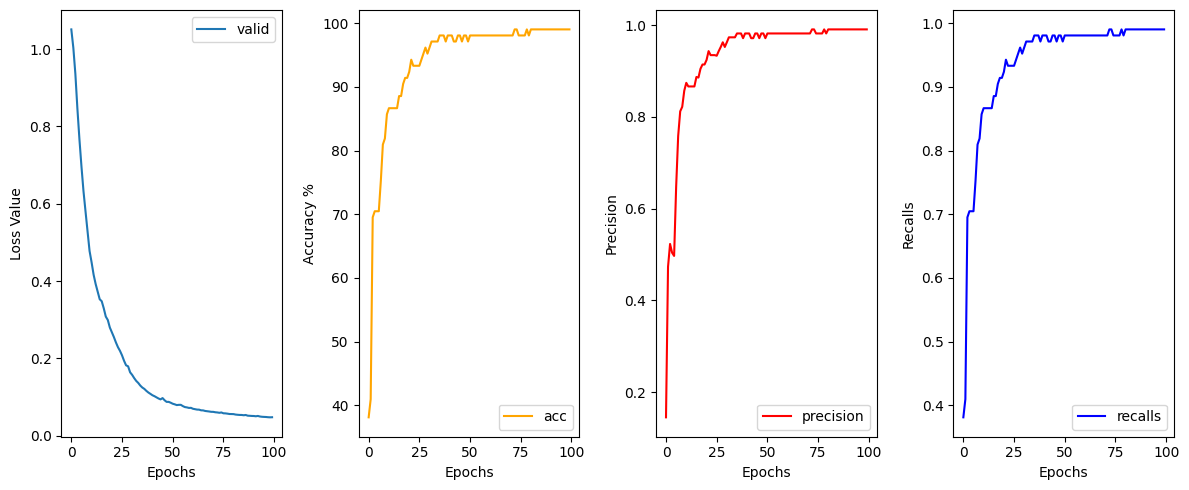

In [18]:
mlp_model = MLPModel()
cnn_model = CNNModel()
rnn_model = RNNModel()

# Definovanie loss funkcie a optimalizatorov

# sluzi na vypocet loss 
criterion = nn.CrossEntropyLoss()

# Optimalizacny algoritmus Adam
# learning rate 0.001
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Trenovanie modelov
print("MLP")
losses_mean, loss_vall_arr, acc_arr, precisions, recalls, final_epochs  = train(mlp_model, criterion, mlp_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, precisions, recalls, final_epochs)
print("CNN")
losses_mean, loss_vall_arr, acc_arr, precisions, recalls, final_epochs  = train(cnn_model, criterion, cnn_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, precisions, recalls, final_epochs)
print("RNN")
losses_mean, loss_vall_arr, acc_arr, precisions, recalls, final_epochs  = train(rnn_model, criterion, rnn_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, precisions, recalls, final_epochs)

In [19]:
def classify_samples(model, features_tensor, labels_tensor):
    # Nastavi model na evaluation mode
    model.eval()
    # requires_grad false
    with torch.no_grad():
        # Predikcia
        predictions = model(features_tensor)
        # Ziska predikovanu class
        _, predicted_classes = torch.max(predictions, 1)

    # Porovnanie predikcii so skutocnymi datami
    for i, (pred, actual) in enumerate(zip(predicted_classes, labels_tensor)):
        predicted_label = iris['target_names'][pred]
        actual_label = iris['target_names'][actual]
        print(f"Sample {i+1}: Predicted - {predicted_label}, Actual - {actual_label}")

In [20]:
# Testuje nové vzorky na MLP modeli, transformuje ich, konvertuje na tenzory, predpovedá triedy a vypisuje názvy predpovedaných tried

new_samples = [
    ([5.1, 3.5, 1.4, 0.2], 0),
    ([6.7, 3.0, 5.2, 2.3], 2),
    ([5.9, 3.0, 4.2, 1.5], 1),
    ([6.1, 2.9, 4.7, 1.4], 1),
    ([4.6, 3.4, 1.4, 0.3], 0)
]

# Rozdelenie features a labels, tuple unpacking
new_features, new_labels = zip(*new_samples)

# Rovnaka scaling transformation ako pre trenovacie data
features_scaled = scaler.transform(np.array(new_features))

# Convert to tensors
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(new_labels, dtype=torch.long)

print("MLP")
classify_samples(mlp_model, features_tensor, labels_tensor)
print("CNN")
classify_samples(cnn_model, features_tensor, labels_tensor)
print("RNN")
classify_samples(rnn_model, features_tensor, labels_tensor)

MLP
Sample 1: Predicted - setosa, Actual - setosa
Sample 2: Predicted - virginica, Actual - virginica
Sample 3: Predicted - versicolor, Actual - versicolor
Sample 4: Predicted - versicolor, Actual - versicolor
Sample 5: Predicted - setosa, Actual - setosa
CNN
Sample 1: Predicted - setosa, Actual - setosa
Sample 2: Predicted - virginica, Actual - virginica
Sample 3: Predicted - versicolor, Actual - versicolor
Sample 4: Predicted - versicolor, Actual - versicolor
Sample 5: Predicted - setosa, Actual - setosa
RNN
Sample 1: Predicted - setosa, Actual - setosa
Sample 2: Predicted - virginica, Actual - virginica
Sample 3: Predicted - versicolor, Actual - versicolor
Sample 4: Predicted - versicolor, Actual - versicolor
Sample 5: Predicted - setosa, Actual - setosa
